1/15/18 

Application of Bayesian Inference to cleaner data


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy
import scipy.optimize
import scipy.misc

import emcee

import seaborn as sns
import pandas as pd

# Import the data as an array
dls_data = np.loadtxt("CorrelationDLS.asc", skiprows=27)

# First few rows include time, temp, etc. Not necessary
# dls_data is now an array of two colums: delay time tau and intensity autocorrelation g^2(tau)

In [2]:
# Unpack imported data
tau = dls_data[:,0]
intensity_ac = dls_data[:,1]

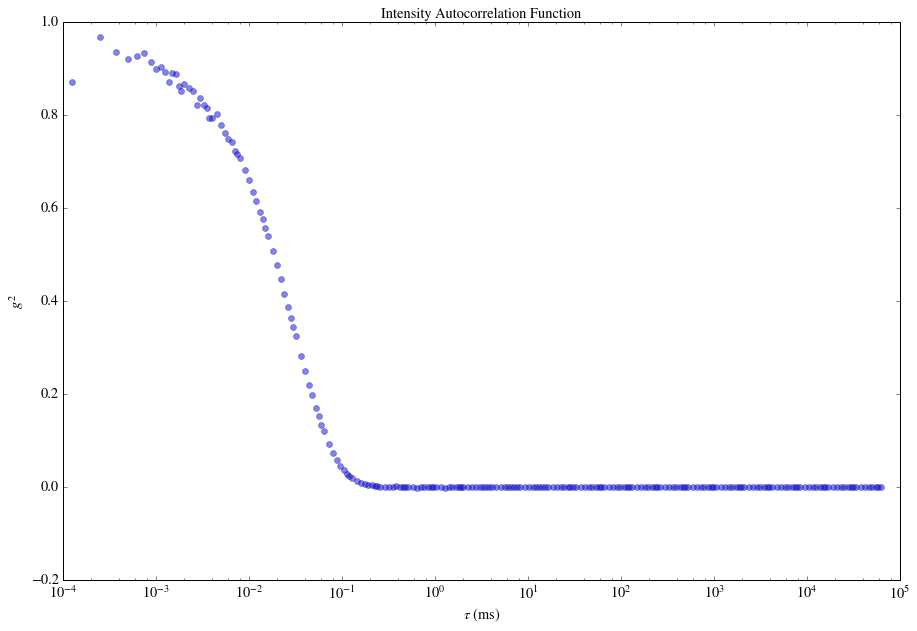

In [3]:
# Graph the tau vs. intensity autocorrelation function
# Plot tau on a log plot

plt.style.use('seaborn-deep')
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fig = plt.figure(figsize = (15, 10))
plt.semilogx(tau, intensity_ac, 'bo', alpha = 0.5)
plt.title("Intensity Autocorrelation Function")
plt.xlabel(r'$\tau $ (ms)')
plt.ylabel(r'$g^2$')

In [4]:
# Apply a uniform error first, then explore the result of different noise modelling
# Let's say that the intensity autocorrelation function has a constant uncertainty of +-5% of the value

sig_y = intensity_ac*0.05


In [5]:
# Now define the log of the liklihood function using the assumption that the prior is equal probablity
def log_prior(theta):
    # returns log of prior probability distribution
    A, C = theta # unpack the model parameters
    
    # Set a uniform prior, but within boundaries. It is not equally likely that the baseline is 1 million as it is
    # that it is one. All values must be positive
    if 0 < A < 10.0 and 0.0 < C < 500.0:
        return 0.0  # Since the probability is 1, this returns 0.
    else:
        return -np.inf # Since the probability is 0 in this region, this returns - infinity.
        
def log_likelihood(theta, x, y, sig_y):
    # returns the log of the likelihood function

    # theta: model parameters (specified as a tuple)
    # x: angles
    # y: measured tau
    # sig_y: uncertainties on measured data, set to be +- 5% of the value
    
    A, C = theta # unpack the model parameters
    
    # Using the model A*np.e**(-C*t), define the log of the likelihood function as
    # ln (L) = K - 1/2 * Sum [(y- function)^2 / sigma^2] 
    # ln (L) = K - 1/2 Chi^2
    # Based on derivation in Hogg, Bovy, and Lang paper
    
    residual = (y - A*np.e**(-C*x))**2
    chi_square = np.sum(residual/(sig_y**2))
    
    # the constant K is determined by the Gaussian function 
    constant = np.sum(np.log(1/np.sqrt(2.0*np.pi*sig_y**2)))
    return constant - 0.5*chi_square

def log_posterior(theta, x, y, sig_y):
    # returns log of posterior probability distribution
    A, C = theta
    
    # Bayes Theorem: Posterior = Prior * likelihood
    # Ln (Posterior) = Ln (Prior ) + Ln (Likelihood)
    return log_prior(theta) + log_likelihood(theta, x, y, sig_y)

In [6]:
# the model has 2 parameters; we'll use 50 walkers and 500 steps each
ndim = 2
nwalkers = 50
nsteps = 500

# set up the walkers in a "Gaussian ball" around the least-squares estimate
# The least squares fit estimate from previous code said that A is about 0.9244, C is about 33.155
ls_result = [0.92445056, 33.15515352] # A, C
starting_positions = [ls_result + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [7]:
# set up the sampler object using emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(tau, intensity_ac, sig_y))


# run the sampler and use iPython's %time directive to tell us how long it took
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

CPU times: user 1.12 s, sys: 11.1 ms, total: 1.13 s
Wall time: 1.14 s
Done


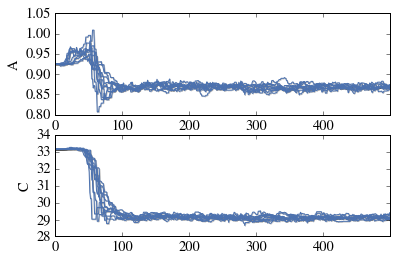

In [9]:
# Plot the movement of the walkers to see how long it takes before they settle into the minimum
plt.style.use('seaborn-deep')
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

fig, (ax_A, ax_C) = plt.subplots(2)
ax_A.set(ylabel='A')
ax_C.set(ylabel='C')

for i in range(10):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_A)
    sns.tsplot(sampler.chain[i,:,1], ax=ax_C)

In [10]:
# Since it takes about 100 steps for the walkers to settle, trim the data to include only steps after 100
samples = sampler.chain[:,100:,:]

# reshape the samples into a 1D array where the colums are A, C
traces = samples.reshape(-1, ndim).T

# create a pandas DataFrame with labels.
parameter_samples = pd.DataFrame({'A': traces[0], 'C': traces[1]})

In [11]:
# calculate the MAP and values using pandas
q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)

q

,A,C
0.16,0.861272,29.003768
0.50,0.867689,29.126947
0.84,0.874227,29.250390


In [12]:
# Fitting data on N(t) = A*e**(-C*t)
def fitmodel(t, C, A):
    return A*np.e**(-C*t)

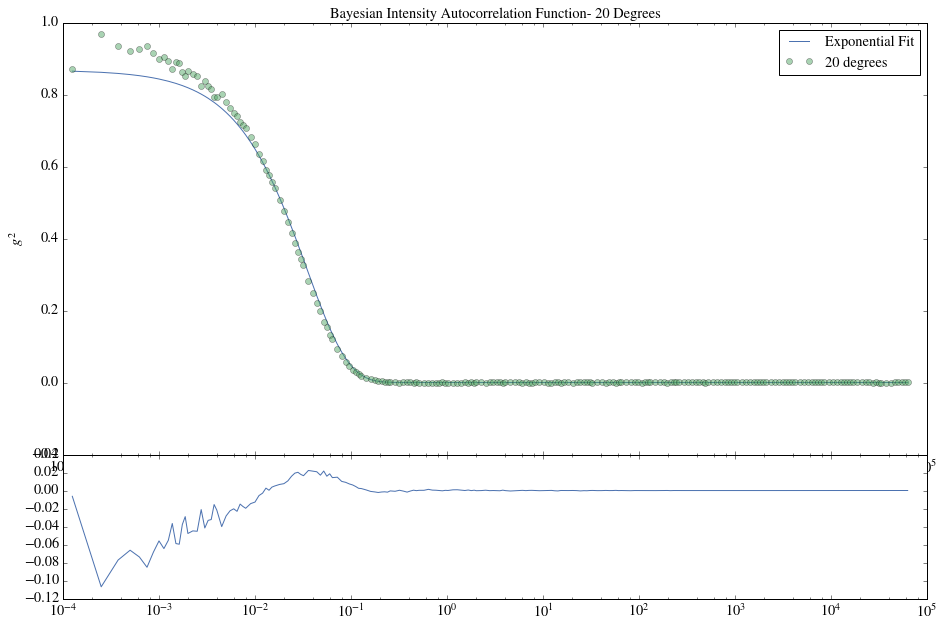

In [13]:
# Plot these fits for the 20 degree data

A = 0.867917
C = 29.132979

fig1 = plt.figure(figsize = (15, 10))
frame1=fig1.add_axes((.1,.3,.8,.6))

plt.semilogx(tau, fitmodel(tau, C, A), label='Exponential Fit')
plt.semilogx(tau, intensity_ac, 'o', alpha = 0.5, label= "20 degrees")

plt.title("Bayesian Intensity Autocorrelation Function- 20 Degrees")
plt.xlabel(r'$\tau $ (ms)')
plt.ylabel(r'$g^2$')
plt.legend()

# Plot the residuals
frame2=fig1.add_axes((.1,.1,.8,.2))
residuals = fitmodel(tau, C, A) - intensity_ac
plt.semilogx(tau, residuals)

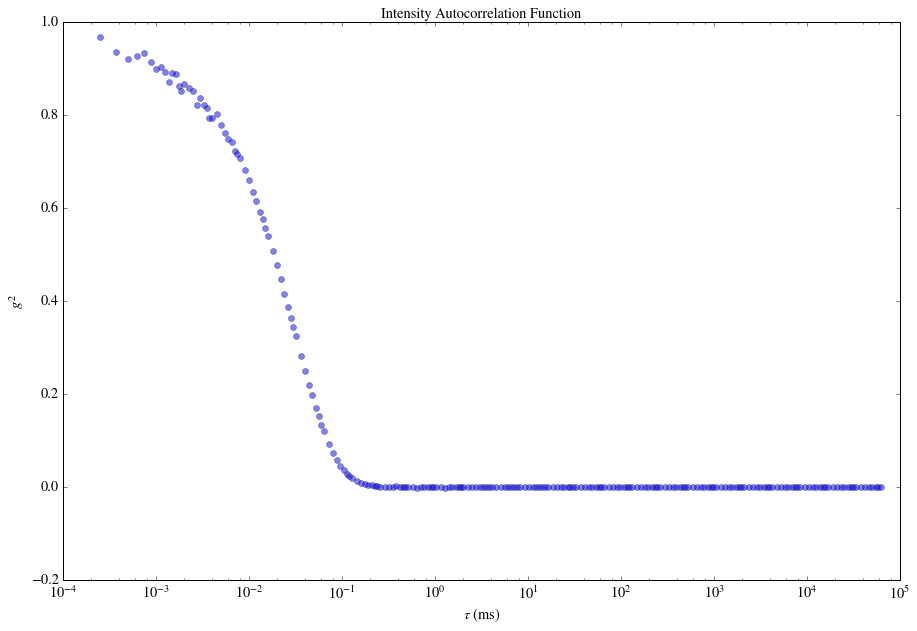

In [14]:
# I don't like that. I'm trimming the data to get rid of that outlyer and seeing what changes
dls_data = np.loadtxt("CorrelationDLS.asc", skiprows=28)

# Unpack imported data
tau = dls_data[:,0]
intensity_ac = dls_data[:,1]

# Graph the tau vs. intensity autocorrelation function
# Plot tau on a log plot

fig = plt.figure(figsize = (15, 10))
plt.semilogx(tau, intensity_ac, 'bo', alpha = 0.5)
plt.title("Intensity Autocorrelation Function")
plt.xlabel(r'$\tau $ (ms)')
plt.ylabel(r'$g^2$')

In [15]:
sig_y = intensity_ac*0.05

ls_result = [0.92445056, 33.15515352] # A, C
starting_positions = [ls_result + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(tau, intensity_ac, sig_y))


# run the sampler and use iPython's %time directive to tell us how long it took
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

CPU times: user 1.14 s, sys: 10.1 ms, total: 1.15 s
Wall time: 1.15 s
Done


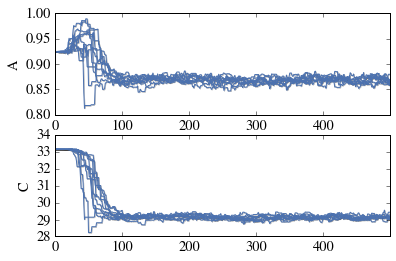

In [16]:
# Plot the movement of the walkers to see how long it takes before they settle into the minimum
fig, (ax_A, ax_C) = plt.subplots(2)
ax_A.set(ylabel='A')
ax_C.set(ylabel='C')

for i in range(10):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_A)
    sns.tsplot(sampler.chain[i,:,1], ax=ax_C)

In [17]:
# Since it takes about 100 steps for the walkers to settle, trim the data to include only steps after 100
samples = sampler.chain[:,100:,:]

# reshape the samples into a 1D array where the colums are A, C
traces = samples.reshape(-1, ndim).T

# create a pandas DataFrame with labels.
parameter_samples = pd.DataFrame({'A': traces[0], 'C': traces[1]})

q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)

q

,A,C
0.16,0.861061,28.996831
0.50,0.867542,29.119737
0.84,0.874209,29.245621


(0.00025000000000000001, 8)

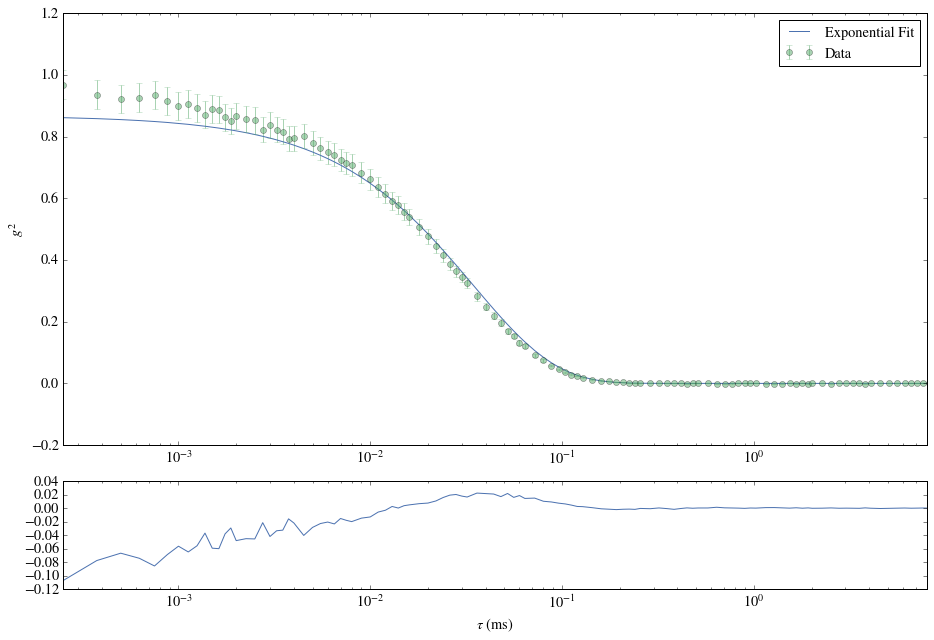

In [36]:
A = 0.867498
C = 29.117980

fig1 = plt.figure(figsize = (15, 10))
frame1=fig1.add_axes((.1,.3,.8,.6))

plt.semilogx(tau, fitmodel(tau, C, A), label='Exponential Fit')
#plt.errorbar(tau, intensity_ac, 'o', alpha = 0.5, label= "20 degrees")
plt.errorbar(tau, intensity_ac,  yerr=sig_y, fmt='o', alpha = 0.5, label = 'Data')

#plt.title("Bayesian Intensity Autocorrelation Function- 20 Degrees")
plt.ylabel(r'$g^2$')
plt.legend()
plt.xlim(10^-4,10^2)

# Plot the residuals
frame2=fig1.add_axes((.1,.1,.8,.15))
residuals = fitmodel(tau, C, A) - intensity_ac
plt.semilogx(tau, residuals)
plt.xlabel(r'$\tau $ (ms)')
plt.xlim(10^-4,10^2)

In [37]:
sum_res = sum(residuals**2)
print sum_res

0.083294129358


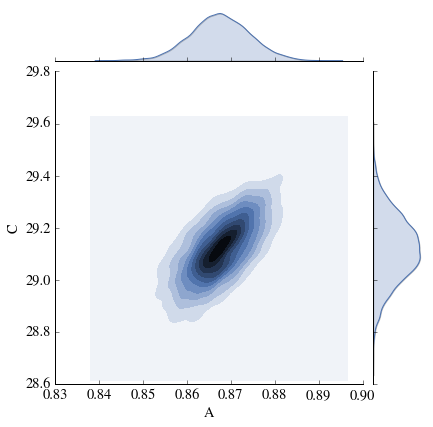

In [27]:
# Obviously this error bar model is allowing for this fit, but let's look at the shape of the pdf as

joint_kde = sns.jointplot(x='A', y='C', data=parameter_samples, kind='kde', stat_func=None)

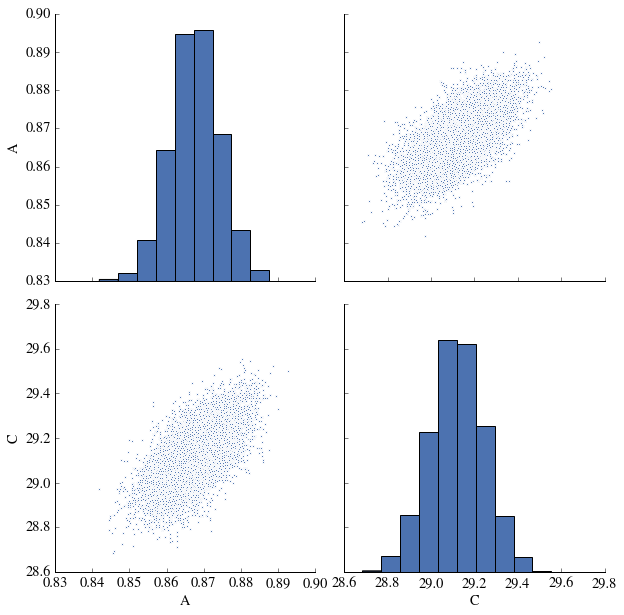

In [29]:
sns.pairplot(parameter_samples, markers='.', size=4.3)

In [38]:
# Determine the diffusion constant D

# Data taken at a scattering angle of 90 degrees with a 632.8 nm HeNe laser.

lam = 632.8e-9 # wavelength in meters
theta = np.pi # scattering angle in radians
n = 1.33200 # refractive index

q = (4*np.pi * n) / (lam) * np.sin(theta/2)

D = (C / q**2) /0.001 # Diffusion constant
print "The diffusion coefficient D is " + str(D) 

The diffusion coefficient D is 4.16165435016e-11


In [39]:
k = 1.38065e-23 # Boltzmann's constant, J/K (joules per kelvin)
T = 297.94999 # Kelvin, from textfile
eta = 8.9e-4 # viscosity of water, Pa s (pascal seconds)

#D = k*T / (6*np.pi*eta*R)

R = (k*T / D) / (6*np.pi*eta)

print "The hydrodynamic radius is " + str(R) + " m."

The hydrodynamic radius is 5.89209629629e-09 m.


In [30]:
# Let's explore the results of using different priors here
# Let's say I'm very sure that the decay constant is around 33 and the amplitude is around 0.92
# Define the prior as wide Gaussians centered around these two values

def log_prior(theta):
    # returns log of prior probability distribution
    A, C = theta # unpack the model parameters
    
    
    return (-(A - 0.92)**2 / 0.05) + (-(C - 33)**2 / 10) # very wide gaussian to allow for more uncertainty

In [31]:
ls_result = [0.92445056, 33.15515352] # A, C
starting_positions = [ls_result + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(tau, intensity_ac, sig_y))


# run the sampler and use iPython's %time directive to tell us how long it took
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

CPU times: user 1.2 s, sys: 13.7 ms, total: 1.21 s
Wall time: 1.23 s
Done


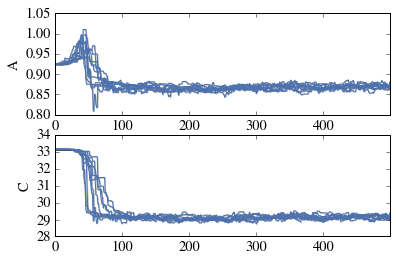

In [32]:
# Plot the movement of the walkers to see how long it takes before they settle into the minimum
fig, (ax_A, ax_C) = plt.subplots(2)
ax_A.set(ylabel='A')
ax_C.set(ylabel='C')

for i in range(10):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_A)
    sns.tsplot(sampler.chain[i,:,1], ax=ax_C)

In [33]:
# Since it takes about 100 steps for the walkers to settle, trim the data to include only steps after 100
samples = sampler.chain[:,100:,:]

# reshape the samples into a 1D array where the colums are A, C
traces = samples.reshape(-1, ndim).T

# create a pandas DataFrame with labels.
parameter_samples = pd.DataFrame({'A': traces[0], 'C': traces[1]})

q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)

q

,A,C
0.16,0.861312,29.004532
0.50,0.867912,29.130150
0.84,0.874319,29.260970


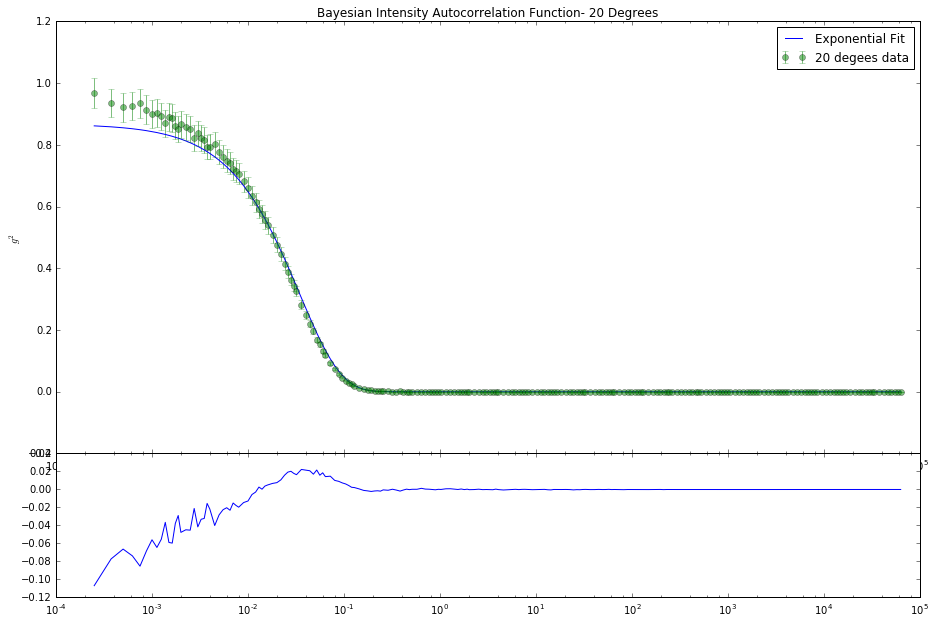

In [53]:
A = 0.868024
C = 29.137671

fig1 = plt.figure(figsize = (15, 10))
frame1=fig1.add_axes((.1,.3,.8,.6))

plt.semilogx(tau, fitmodel(tau, C, A), label='Exponential Fit')
#plt.errorbar(tau, intensity_ac, 'o', alpha = 0.5, label= "20 degrees")
plt.errorbar(tau, intensity_ac,  yerr=sig_y, fmt='o', alpha = 0.5, label = '20 degees data')

plt.title("Bayesian Intensity Autocorrelation Function- 20 Degrees")
plt.xlabel(r'$\tau $ (ms)')
plt.ylabel(r'$g^2$')
plt.legend()

# Plot the residuals
frame2=fig1.add_axes((.1,.1,.8,.2))
residuals = fitmodel(tau, C, A) - intensity_ac
plt.semilogx(tau, residuals)

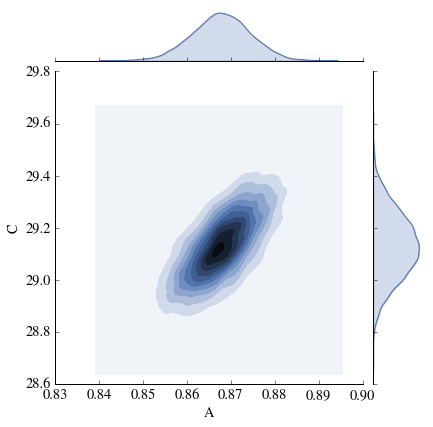

In [34]:
joint_kde = sns.jointplot(x='A', y='C', data=parameter_samples, kind='kde', stat_func=None)

In [55]:
percent_diff_A = (0.868024-0.867917)/ (0.5*(0.868024+0.867917))

percent_diff_C = (29.137671-29.117980)/ (0.5*(29.137671+29.117980))
print "The percent difference for A is " + str(percent_diff_A*100) + "%"
print "The percent difference for C is " + str(percent_diff_C*100) + "%"

The percent difference for A is 0.0123276079083%
The percent difference for C is 0.0676020254241%


In [56]:
chi = sum(residuals**2)
print chi

0.0819842155086
